[1. Vorbereitung](#Vorbereitung)<br>
&ensp;[1.1 Bibliotheken importieren](#Bibliotheken-importieren)<br>
&ensp;[1.2 Zugriff von Google Drive erhalten](#Zugriff-von-Google-Drive-erhalten)<br>
[2. Übung mit synthetischer Daten](#Uebung-1)<br>
&ensp;[2.1 Erzeugung synthetischer Daten](#Uebung-1-1)<br>
&ensp;[2.2 Exploration der Daten](#Uebung-1-2)<br>
&ensp;[2.3 Datenvorverarbeitung](#Uebung-1-3)<br>
&ensp;[2.4 Umsetzung Objekterkennung mit einem Convolutional Neural Network](#Uebung-1-4)<br>
&ensp;[2.5 Evaluation Objekterkennung](#Uebung-1-5)<br>
&ensp;[2.6 Augumentierung der Daten](#Uebung-1-6)<br>
&ensp;[2.7 Training mit augumentiertem Datensatz](#Uebung-1-7)<br>
&ensp;[2.8 Evaluation des neuen Modells](#Uebung-1-8)<br>
[3. Übung mit realer Daten](#Uebung-2)<br>
&ensp;[3.1 Exploration des realen Datensatzes](#Uebung-2-1)<br>
&ensp;[3.2 Datenvorverarbeitung für den realen Datensatz](#Uebung-2-2)<br>
&ensp;[3.3 Augumentierung des realen Datensatzes](#Uebung-2-3)<br>
&ensp;[3.4 Objekterkennung für den realen Datensatz](#Uebung-2-4)<br>
&ensp;[3.5 Evaluation für den realen Datensatz](#Uebung-2-5)<br>










<a name="Vorbereitung"></a>
## 1. Vorbereitung

<a name="Bibliotheken-importieren"></a>
### 1.1 Bibliotheken importieren

In [21]:
import numpy as np
import os
import json
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
from IPython import display

import tensorflow as tf
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer, MaxPool2D, Input
from keras.losses import MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from skimage import transform
from skimage.transform import rotate
from skimage.util import random_noise
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<a name="Zugriff-von-Google-Drive-erhalten"></a>
### 1.2 Zugriff von Google Drive erhalten

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/KI-WS

Mounted at /content/drive/
/content/drive/My Drive/KI-WS


<a name="Uebung-1"></a>
## 2. Übung mit synthetischer Daten

<a name="Uebung-1-1"></a>
### 2.1 Erzeugung synthetischer Daten

#### Aufgabe 2.1.1:

Für den ersten Teil der Übung soll nun ein recht simpler synthetischer Datensatz erzeugt werden. Zu diesem Zweck sollen synthetische Bilder generiert werden, auf denen jeweils ein einfaches geometrisches Objekt zu sehen ist. Im weiteren Verlauf der Übung soll dann eine Objekterkennung für diesen Datensatz umgesetzt werden. Führen Sie die folgenden Codezellen aus. Welche Informationen über den Datensatz können Sie aus der Codezelle ziehen?

In [4]:
# Parameter Synthetische Daten

num_imgs = 1000 # Anzahl der erzeugten Bilder

img_size = 224 # Größe der Bilder -> 224 x 224 Pixel
min_object_size = 40 # Minimale Größe des Objekts im Bild
max_object_size = 80 # Maximale Größe des Objekts im Bild

num_classes = 3 # Anzahl der Objektklassen
class_labels = ['Rechteck', 'Kreis', 'Dreieck'] # Namen der Objektklassen

#### Aufgabe 2.1.2:

Neben den Bilddaten müssen dafür auch die entsprechenden Labels erzeugt werden. Hier wird für jedes Bild zum einen die Position des Objekts in Form einer Bounding Box und zum anderen die Klasse des Objekts als Labels generiert. In welcher Form werden die Bilder und die Labels hier gespeichert?  

In [7]:
# Array für die erzeugten Bilder
imgs = np.zeros((num_imgs, img_size, img_size, 3), dtype=np.uint8)
print("imgs:", imgs.shape)

# Array für die zugehörigen Bounding Boxen
bboxes = np.zeros((num_imgs, 4))
print("bboxes:", bboxes.shape)

# Array für die zugehörigen Klassen
classes = np.zeros((num_imgs, num_classes), dtype=int)
print("classes:", classes.shape)

min_distance_wall = 5 # minimaler Abstand der Objekte vom Bildrand

imgs: (1000, 224, 224, 3)
bboxes: (1000, 4)
classes: (1000, 3)


In [9]:
%run Loesung/Loesung_2_1_2.py

Die Bilder werden als 4D-Matrix der Form (Anzahl Bilder, Bildbreite in Pixel, Bildhöhe in Pixel, Farbkanäle (RGB)) gespeichert. Die zugehörigen Bounding Boxen werden als 2D-Matrix der Form (Anzahl Bilder, Anzahl Werte Bounding Box) gespeichert, wobei die Bounding Boxen durch 4 Werte, die Koordinaten der linken oberen Ecke und der rechten unteren Ecke angegeben werden. Die zugehörigen Klassen werden als 2D-Matrix der Form (Anzahl Bilder, Anzahl Klassen) gespeichert. Für die Angabe der Klassen wird hier One-hot-Encoding verwendet.


#### Aufgabe 2.1.3:

Betrachten Sie den folgenden Code für die Erzeugung der synthetischen Bilddaten. Wie wird hier ein synthetisches Bild generiert?

In [10]:
for i_img in range(num_imgs):

    img = np.ones((img_size,img_size,3), np.uint8) * 255 # Erzeugung eines weißen Bildes

    obj_class = np.random.randint(num_classes) #zufällige Wahl der Objektklasse

    c1, c2, c3 = np.random.randint(0, 150, size=3)
    mycolor =  (int(c1), int(c2),int(c3)) # zufällige Farbe

    classes[i_img, obj_class] = 1 # Speichern der Klasse, One-Hot-Encoding

    if obj_class == 0: #Rechteck
        w, h = np.random.randint(min_object_size, max_object_size, size=2) # Breite und Höhe
        x = np.random.randint(min_distance_wall, img_size - w -min_distance_wall) # x-Position im Bild
        y = np.random.randint(min_distance_wall, img_size - h -min_distance_wall) # y-Position im Bild
        cv.rectangle(img, (x+0,y+0), (x+w-1,y+h-1), mycolor, -1) # Erzeugung Rechteck im Bild
        bbox = [x, y+h, x+w, y] # Bounding Box

    elif obj_class == 1: # Kreis
        r = 0.5 * np.random.randint(min_object_size, max_object_size) # Radius
        x = np.random.randint(r+2, img_size-r-2) # x-Position im Bild
        y = np.random.randint(r+2, img_size-r-2) # y-Position im Bild
        cv.circle(img,(x,y), int(r), mycolor, -1) # Erzeugung Kreis im Bild
        bbox = [x-r, y+r, x+r, y-r] # Bounding Box

    elif obj_class == 2: # Dreieck
        w, h = np.random.randint(min_object_size, max_object_size, size=2) # Breite und Höhe
        x = np.random.randint(min_distance_wall, img_size - w -min_distance_wall) # x-Position im Bild
        y = np.random.randint(min_distance_wall, img_size - h -min_distance_wall) # y-Position im Bild
        triangle_cnt = np.array( [(x,y), (x+w,y), (x,y+h)] )
        cv.drawContours(img, [triangle_cnt], 0, mycolor, -1) # Erzeugung Dreieck im Bild
        bbox = [x, y+h, x+w, y] # Bounding Box

    imgs[i_img] = img
    bboxes[i_img] = bbox

In [11]:
%run Loesung/Loesung_2_1_3.py

Um ein synthetisches Bild zu generieren, wird zunächst ein weißes Bild erzeugt. Danach wird zufällig eine der drei Objektklassen ausgewählt und eine zufällige Farbe für das Objekt bestimmt. Die Klasse wird in Form von One-Hot-Encoding gespeichert. Anschließend wird die Größe und Position des Objekts, innerhalb vorgegebener Grenzen, zufällig gewählt und das Objekt im Bild erzeugt. Als Letztes wird die Bounding Box des Objekts berechnet und gespeichert.


<a name="Uebung-1-2"></a>
### 2.2 Exploration der Daten

#### Aufgabe 2.2.1:

Überprüfen Sie die erzeugten synthetischen Daten stichprobenhaft. Enthält jedes Bild eines der drei geometrischen Objekte? Sind die Labels, d. h. die Bounding Boxen und die Klassen korrekt? Sind alle Objekte vollständig im Bild? Etc.

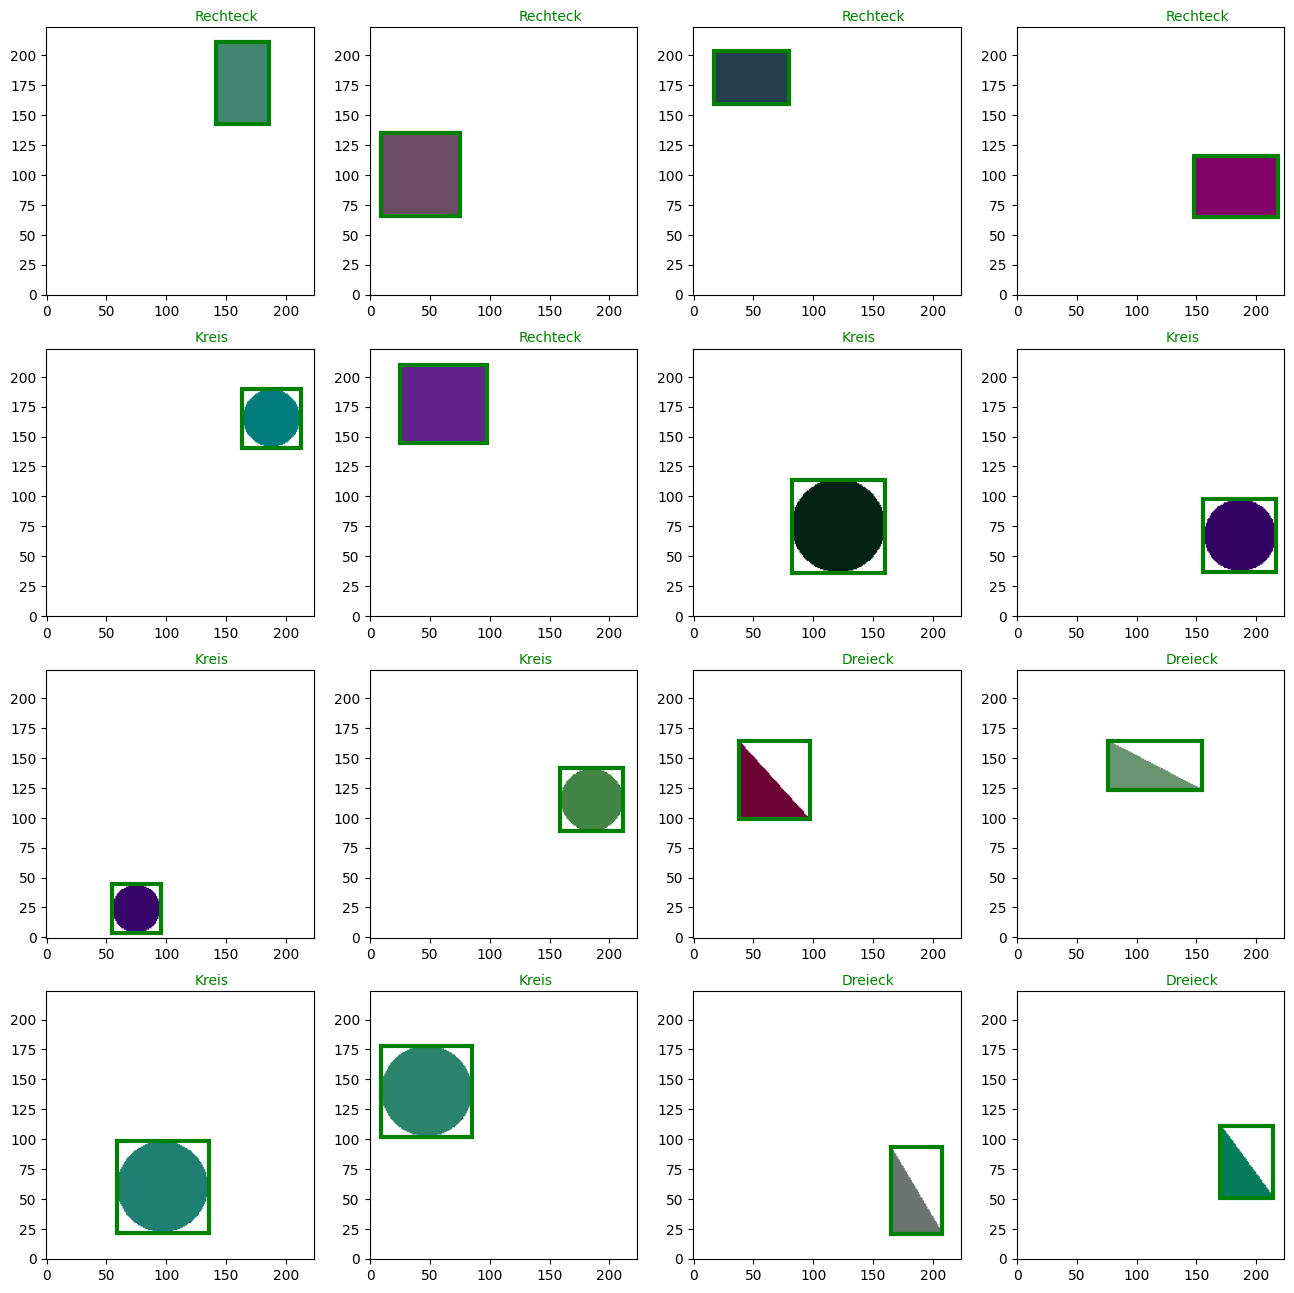

In [13]:
temp_imgs = np.copy(imgs) # Erzeugung einer Kopie der Bilder

# Plotten von einigen Beispielbildern
def plot_example_imgs(imgs,bboxes,classes):

    plt.figure(figsize=(16, 16))
    for i_subplot in range(1, 17):
        plt.subplot(4, 4, i_subplot)
        i = np.random.randint(len(imgs))

        # Bild
        plt.imshow(imgs[i], origin='lower')
        ax = plt.gca()

        # Bounding Box
        x, y = bboxes[i,0], bboxes[i,3]
        w, h = (bboxes[i,2] - bboxes[i,0]), (bboxes[i,1] - bboxes[i,3])
        box = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='g', facecolor="none")
        ax.add_patch(box)

        # Klasse
        class_num = np.argmax(classes[i])
        plt.text(imgs.shape[2]-100,imgs.shape[1]+5, class_labels[class_num], color='g')

plot_example_imgs(temp_imgs,bboxes,classes)

#### Aufgabe 2.2.2:

Wie sind die Daten auf die Klassen verteilt?

In [14]:
class_dist = np.sum(classes, axis=0)/np.sum(classes)
for i in range(3):
    print(class_labels[i], class_dist[i]*100, "%")

Rechteck 33.7 %
Kreis 32.7 %
Dreieck 33.6 %


In [15]:
%run Loesung/Loesung_2_2_2.py

Wird die Musterlösung ausgeführt, sind die Daten relativ gleichmäßig auf die drei Klassen verteilt. Dies ist auch zu erwarten, da die drei Klassen bei der Erzeugung der Bilddaten mit gleicher Wahrscheinlichkeit ausgewählt werden.


<Figure size 640x480 with 0 Axes>

<a name="Uebung-1-3"></a>
### 2.3 Datenvorverarbeitung

#### Aufgabe 2.3.1:

Im ersten Schritt der Datenvorverarbeitung werden die Pixelwerte neu skaliert. Was genau wird hier gemacht und warum?

In [16]:
def pixel_normalization(imgs):

    h = imgs.shape[1]
    b = imgs.shape[2]

    imgs = tf.cast(imgs, tf.float32)
    s = tf.constant(255.0,  dtype = tf.float32)
    imgs_scaled = tf.math.divide(imgs,s)

    print("Vorher:")
    print(tf.reshape(imgs[0],(h,b,3)))
    print("Nachher:")
    print(tf.reshape(imgs_scaled[0],(h,b,3)))

    return imgs_scaled

imgs_scaled = pixel_normalization(imgs)

Vorher:
tf.Tensor(
[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]], shape=(224, 224, 3), dtype=float32)
Nachher:
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
 

In [17]:
%run Loesung/Loesung_2_3_1.py

Die Pixelwerte werden normalisiert, d. h. sie werden von Werten zwischen 0 und 255 auf Werte zwischen 0 und 1 skaliert. Für das Training von neuronalen Netzen sollten die Eingabewerte im Allgemeinen klein sein (Faustregel zwischen 0 und 1) und sich in der gleichen Größenordnung bewegen. Sind die Wertebereiche der Eingabedaten sehr unterschiedlich oder enthalten die Eingabedaten sehr große Werte, hat dies in der Regel einen negativen Einfluss auf das Training und die Performance des Netzes.


#### Aufgabe 2.3.2

Im nächsten Schritt der Datenvorverarbeitung werden auch die Bounding Boxen neu skaliert. Was genau wird hier gemacht und warum?  

In [18]:
def bbox_normalization(bboxes, imgs):

    print("Vorher: min", np.min(bboxes), "max", np.max(bboxes))

    bboxes_new = bboxes

    h = imgs.shape[1]
    b = imgs.shape[2]

    bboxes_new[:,0] = bboxes[:,0]/b
    bboxes_new[:,1] = bboxes[:,1]/h
    bboxes_new[:,2] = bboxes[:,2]/b
    bboxes_new[:,3] = bboxes[:,3]/h

    print("Nachher: min", np.min(bboxes), "max", np.max(bboxes))

    return bboxes_new

bboxes_scaled = bbox_normalization(bboxes, imgs)

Vorher: min 1.5 max 221.0
Nachher: min 0.006696428571428571 max 0.9866071428571429


In [19]:
%run Loesung/Loesung_2_3_2.py

Die Bounding Box Werte werden normalisiert, d. h. sie werden von Werten zwischen 0 und 224 (Größe der Bilder) auf Werte zwischen 0 und 1 skaliert. Ähnlich wie bei den Eingabewerten, führt die Skalierung der Labels auf den Wertebereich [0,1] in der Regel zu einer Beschleunigung des Trainings und einer besseren Performance des Netzes.


#### Aufgabe 2.3.3:

Als Nächstes muss der erzeugte synthetische Datensatz in Trainingsdaten und Testdaten aufgeteilt werden. Dabei sollen 80 % der Daten als Trainingsdaten und 20 % der Daten als Testdaten verwendet werden. Ergänzen Sie den gegebenen Code.

In [20]:
# Durchmischen der Daten vor der Aufteilung
imgs_scaled_np = np.array(imgs_scaled)
imgs_scaled_np, bboxes_scaled, classes = shuffle(imgs_scaled_np, bboxes_scaled, classes)

n_train = int(0.8 * num_imgs) #Anzahl der Bilder, die zum Trainingsdatensatz gehören sollen

# Trainingsdaten
x_train = imgs_scaled_np[:n_train] # Die ersten n_train Bilder gehören zum Trainingsdatensatz
bboxes_train = bboxes_scaled[:n_train]
class_train = classes[:n_train]

# Testdaten
x_test = imgs_scaled_np[n_train:] # Die restlichen Bilder gehören zum Testdatensatz
bboxes_test = bboxes_scaled[n_train:]
class_test = classes[n_train:]

print("Anzahl Bilder Trainingsdatensatz: ", len(x_train))
print("Anzahl Bilder Testdatensatz: ", len(x_test))

Anzahl Bilder Trainingsdatensatz:  800
Anzahl Bilder Testdatensatz:  200


<a name="Uebung-1-4"></a>
### 2.4 Umsetzung Objekterkennung mit einem Convolutional Neural Network

Im Folgenden soll eine Objekterkennung mit einem Convolutional Neural Network (CNN) für die erzeugten synthetischen Daten umgesetzt werden. Auf die Funktionsweise von CNNs wird später im Modul Qualitätsprüfung eingegangen. Hier werden Sie zunächst als Black Box betrachtet. Der Aufbau des verwendeten Netzes wurde im Kurselement "Objekterkennung mit tiefen neuronalen Netzen" genauer erläutert und ist zur Erinnerung in der folgenden Grafik noch einmal dargestellt.

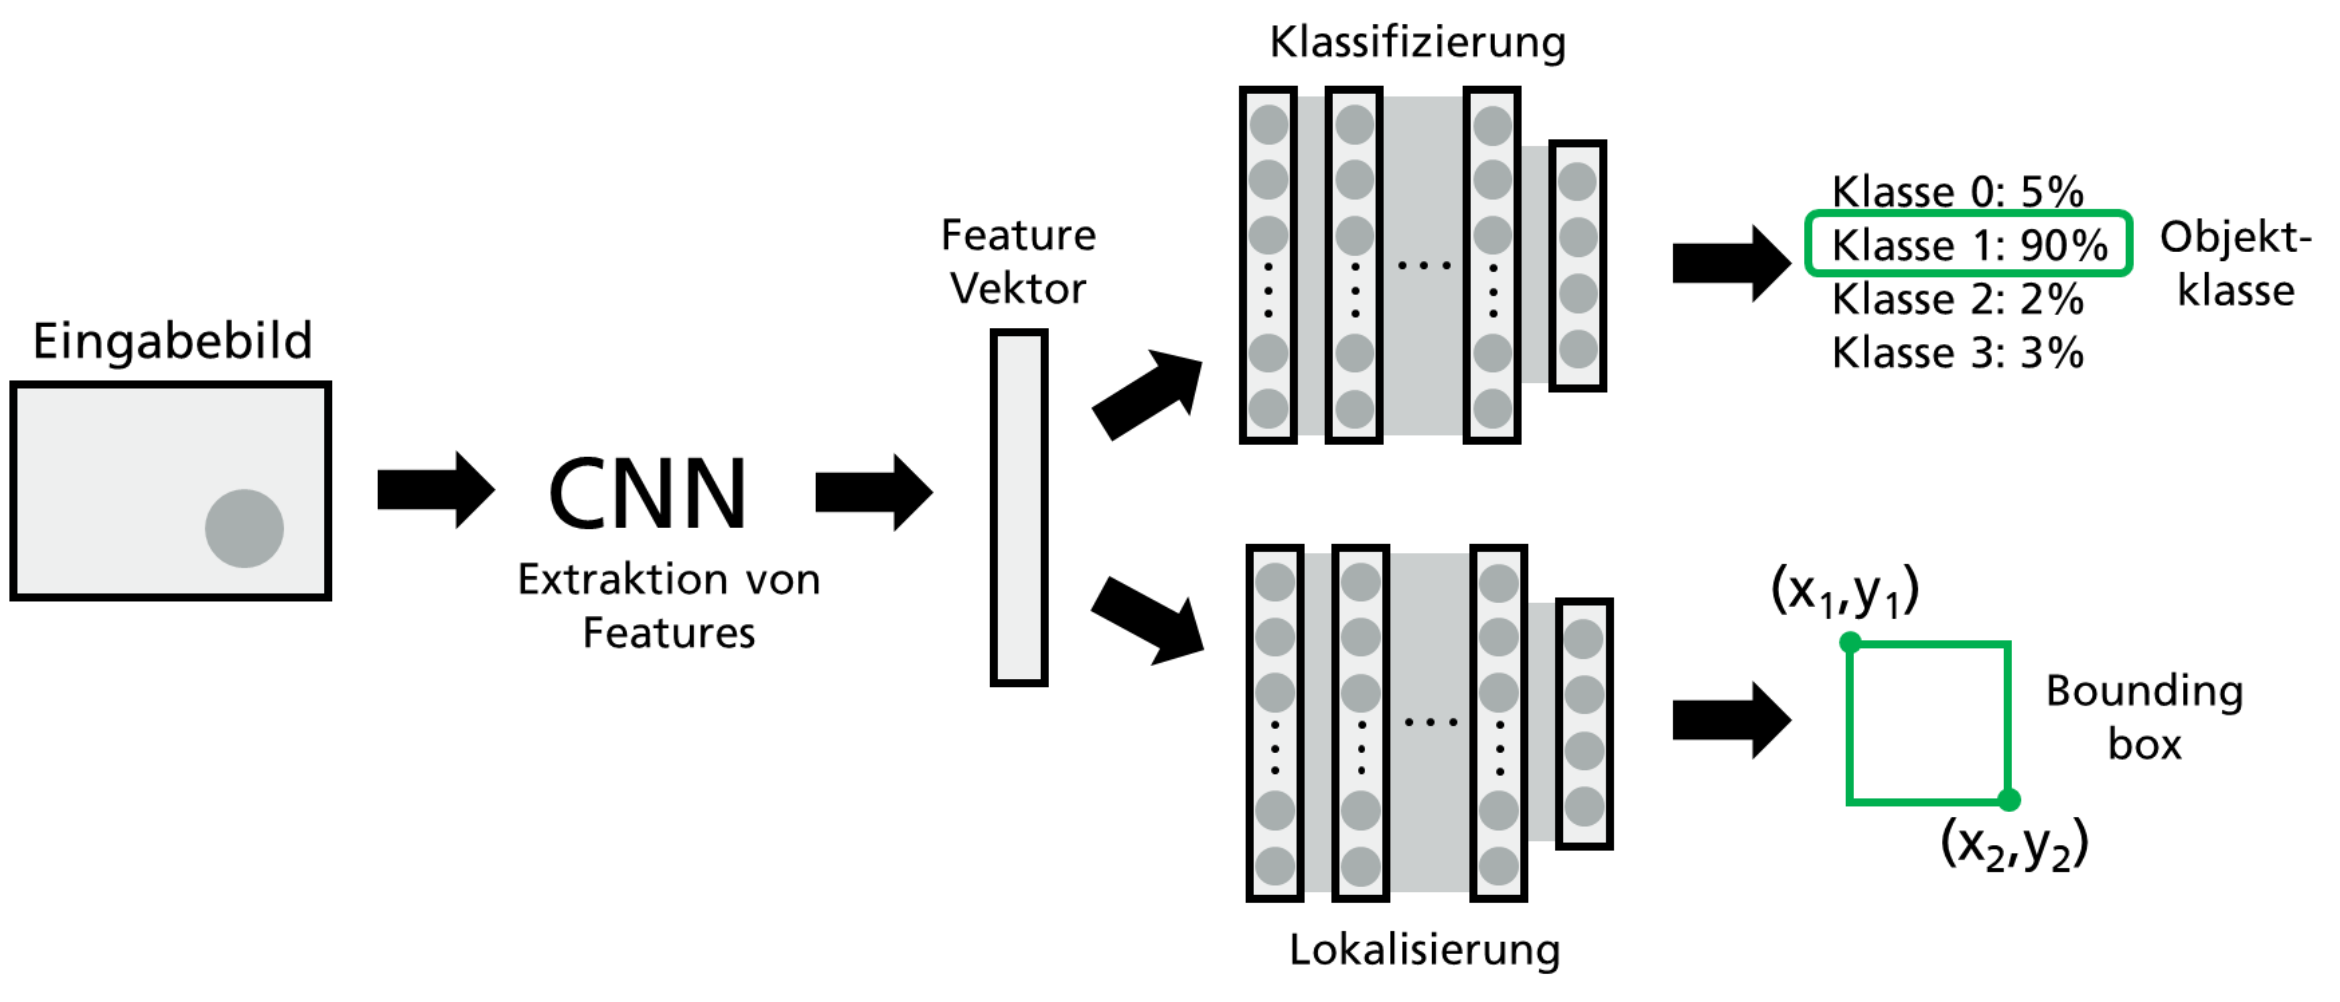

In [22]:
display.Image("Netzarchitektur.png")

#### Aufgabe 2.4.1:

Betrachten Sie die Abbildung der Netzwerkarchitektur und versuchen Sie den gegebenen Code für die Erstellung des Modells nachzuvollziehen.

Wie Sie dem Code entnehmen können, werden drei verschiedene Aktivierungsfunktionen für die verschiedenen Schichten des Netzes verwendet. Welche sind das und wie sehen diese Aktivierungsfunktionen aus? Warum macht es Sinn diese für die entsprechenden Schichten des Netzes zu verwenden?

Informationen zu verschiedenen Aktivierungsfunktionen und Hinweise zur Lösung der Aufgabe finden Sie u. a. hier: https://www.geeksforgeeks.org/activation-functions-neural-networks/  

In [24]:
def build_model():

    # Eingabe
    inputs = Input(shape=x_train.shape[1:])

    # CNN
    x = Convolution2D(filters=32,kernel_size=(3,3), activation="relu")(inputs)
    x = MaxPool2D(pool_size=(3,3))(x)
    x = Convolution2D(filters=16,kernel_size=(3,3), activation="relu")(x)
    x = MaxPool2D(pool_size=(3,3))(x)
    x = Convolution2D(filters=8,kernel_size=(3,3), activation="relu")(x)
    x = MaxPool2D(pool_size=(3,3)) (x)
    x = Flatten() (x)

    # Lokalisierung (Regressionsproblem)
    x_1 = Dense(128, activation="relu")(x)
    x_1 = Dropout(0.3)(x_1)
    x_1 = Dense(64,  activation="relu")(x_1)
    x_1 = Dropout(0.3)(x_1)
    output_bb = Dense(4, activation="sigmoid", name='output_bb')(x_1) # Ausgabe Bounding Box

    # Klassifizierung (Klassifikationsproblem)
    x_2 = Dense(64, activation="relu")(x)
    x_2 = Dropout(0.3)(x_2)
    x_2 = Dense(32, activation="relu")(x_2)
    x_2 = Dropout(0.3)(x_2)
    output_class = Dense(3, activation="softmax", name='output_class')(x_2) # Ausgabe Wahrscheinlichkeit Objektklasse

    model = Model(inputs=inputs, outputs=[output_bb, output_class])
    return model

model = build_model()

# Speichern der zufällig initialisierten Gewichte des Modells
model.save_weights('model_default.weights.h5')

In [ ]:
%run Loesung/Loesung_2_4_1.py

#### Aufgabe 2.4.2:

Betrachten Sie den folgenden Code und führen Sie ihn aus, um das erstellte Modell zu trainieren. Das Training des Modells benötigt ca. 20 Minuten. Nutzen Sie diese Zeit, um die folgenden Fragen zu beantworten.

a) Wie wird hier der Fehler zwischen den Vorhersagen des Netzes und den gegebenen Labels (Loss) berechnet?

b) Welcher Anteil der Trainingsdaten wird für die Validierung verwendet?

c) Welche Gewichte werden während des Trainings des Modells gespeichert?

Falls das Training zu lange dauert, können Sie auch die Musterlösung laden.   

In [25]:
lr = 0.001 # Lernrate
num_epochs = 40 # Anzahl Epochen
batch_size = 64 # Batch size

# Gewichtung der Fehler
w_1 = 10.0 # Lokalisierung
w_2 = 1.0 # Klassifizierung

# Laden der zufälligen Startgewichte des Netzes
model.load_weights('model_default.weights.h5')

opt = Adam(learning_rate=lr)

model.compile(loss={'output_bb' : 'mean_squared_error', 'output_class' : 'categorical_crossentropy'},
              loss_weights={'output_bb' : w_1, 'output_class' : w_2},# loss_weights=[w_1,w_2]
              optimizer=opt,
              metrics=['mae','accuracy'])

model_checkpoint_callback = ModelCheckpoint(
                            filepath="my_model.keras",
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            save_weights_only=False)

history = model.fit(
                    x_train,
                    (bboxes_train, class_train),
                    batch_size=batch_size,
                    epochs=num_epochs,
                    callbacks=[model_checkpoint_callback],
                    validation_split=0.2)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 1.7211 - output_bb_loss: 0.6068 - output_bb_mae: 0.2030 - output_class_accuracy: 0.3157 - output_class_loss: 1.1143 - val_loss: 1.5131 - val_output_bb_loss: 0.4097 - val_output_bb_mae: 0.1743 - val_output_class_accuracy: 0.3000 - val_output_class_loss: 1.1056
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 1.5175 - output_bb_loss: 0.4159 - output_bb_mae: 0.1736 - output_class_accuracy: 0.3577 - output_class_loss: 1.1015 - val_loss: 1.4013 - val_output_bb_loss: 0.3037 - val_output_bb_mae: 0.1471 - val_output_class_accuracy: 0.3438 - val_output_class_loss: 1.0996
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - loss: 1.3881 - output_bb_loss: 0.2895 - output_bb_mae: 0.1414 - output_class_accuracy: 0.3175 - output_class_loss: 1.0986 - val_loss: 1.2142 - val_output_bb_loss: 0.1135 - val_output_bb_mae: 0.0837 - val_output_class_accuracy: 0.3625 - val_output_class_loss: 1.1034
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/s

In [ ]:
%run Loesung/Loesung_2_4_2_a.py

In [ ]:
%run Loesung/Loesung_2_4_2_b.py

In [ ]:
%run Loesung/Loesung_2_4_2_c.py

In [34]:
# Sie können entweder mit dem von Ihnen trainierten Netz weiterarbeiten oder mit der Musterlösung

# Von Ihnen trainiertes Netz laden
model.load_weights('my_model.keras')

# Musterlösung laden
#model.load_weights('solution_model.keras')

<a name="Uebung-1-5"></a>
### 2.5 Evaluation Objekterkennung




#### Aufgabe 2.5.1:

Testen Sie das trainierte neuronale Netz auf einigen Beispielbildern aus dem Testdatensatz. Wie gut funktioniert die Lokalisierung und die Klassifikation der Objekte?  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


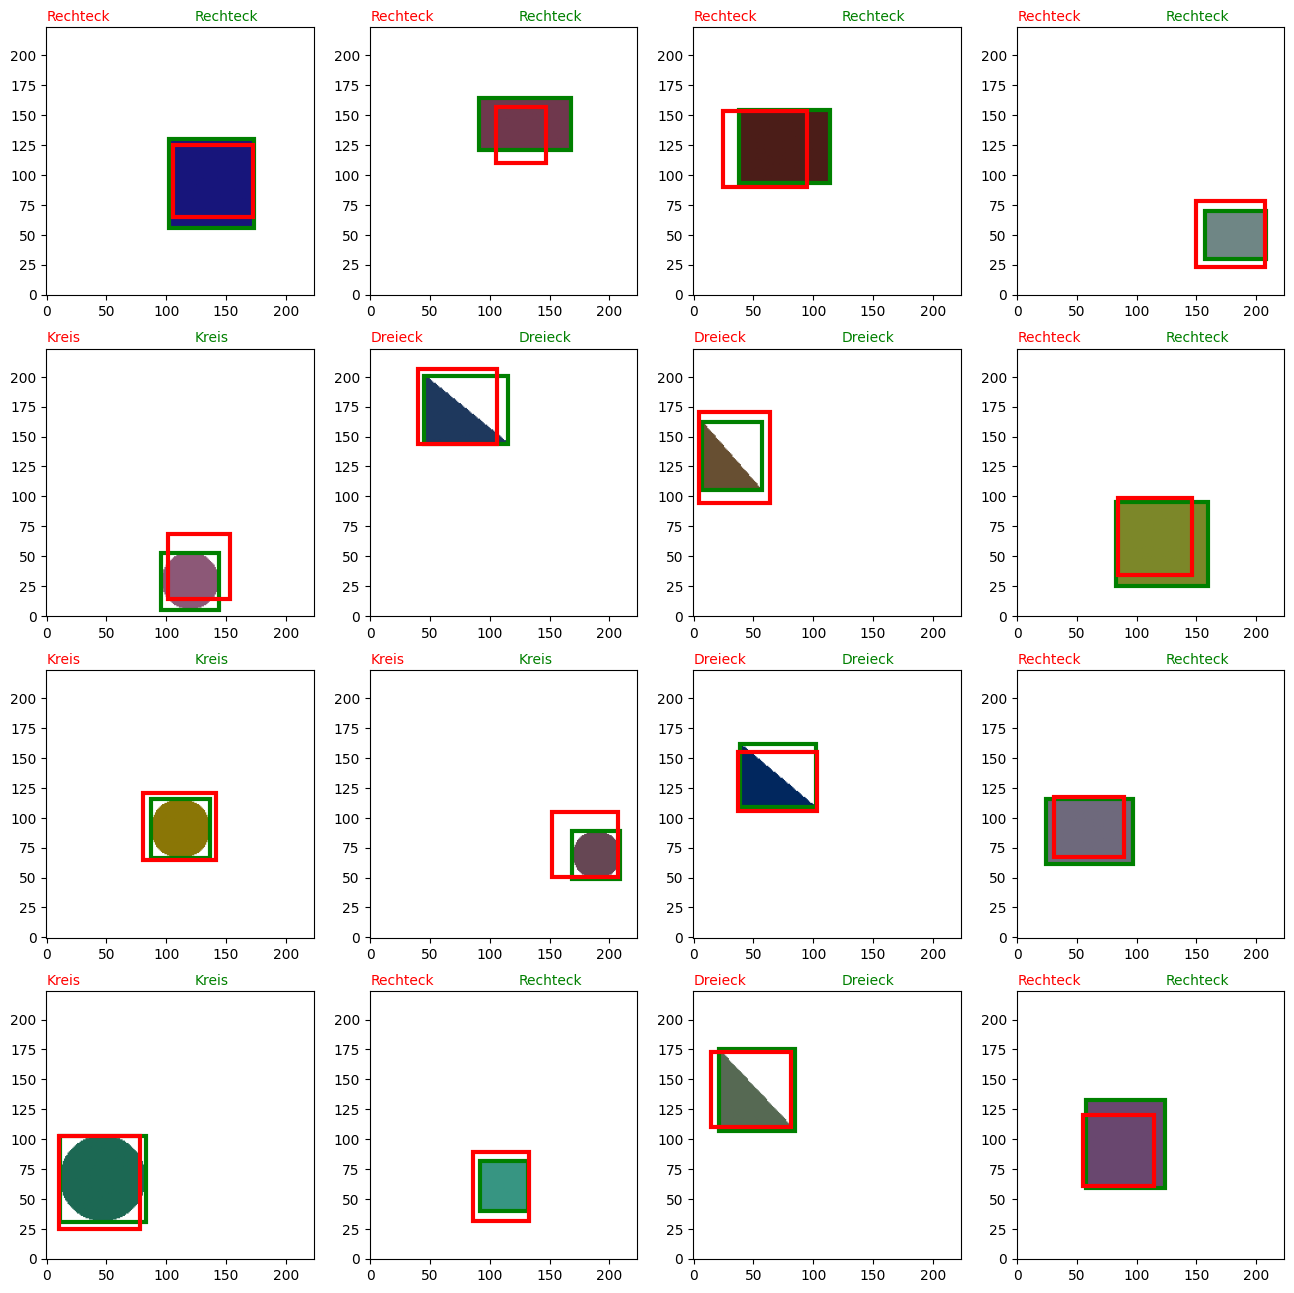

In [27]:
# Wähle zufällig 16 Bilder aus dem Testdatensatz und plotte die korrekten und die vom Netz vorhergesagten Bboxes und Klassen
def plot_example_imgs_pred(x_test, bboxes_test, class_test, img_size, model):

    # Wähle zufällig 16 Bilder aus dem Testdatensatz
    myPlotSample = np.array(x_test)
    rnd_sample = np.random.randint(len(myPlotSample), size=16)
    images_show = myPlotSample[rnd_sample]

    # korrekte Bounding Boxen und Klassen
    true_bboxes = bboxes_test[rnd_sample]*img_size
    true_class = class_test[rnd_sample]

    # Wende das trainierte neuronale Netz an, um Bounding Boxen und Objektklassen für die Testbilder vorherzusagen
    pred_y = model.predict(images_show)
    pred_bboxes = pred_y[0]*img_size
    pred_class = pred_y[1]

    # Plotte testbilder
    plt.figure(figsize=(16, 16))
    for i in range(16):

        plt.subplot(4, 4, i+1)
        plt.imshow(images_show[i], origin='lower')
        ax = plt.gca()

        # korrekte Bounding Boxen (grün)
        x, y = true_bboxes[i,0], true_bboxes[i,3]
        w, h = (true_bboxes[i,2] - true_bboxes[i,0]), (true_bboxes[i,1] - true_bboxes[i,3])
        box_true = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='g', facecolor="none")
        ax.add_patch(box_true)

        # vorhergesagte Bounding Boxen (rot)
        x, y = pred_bboxes[i,0], pred_bboxes[i,3]
        w, h = (pred_bboxes[i,2] - pred_bboxes[i,0]), (pred_bboxes[i,1] - pred_bboxes[i,3])
        box_pred = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor="none")
        ax.add_patch(box_pred)

        # vorhergesagte und korrekte Klasse
        predicted_class_num = np.argmax(pred_class[i])
        true_class_num = np.argmax(true_class[i])
        plt.text(0,x_test.shape[1]+5,class_labels[predicted_class_num], color='r') # vorhergesagte Klasse (rot)
        plt.text(x_test.shape[2]-100,x_test.shape[1]+5, class_labels[true_class_num], color='g') # korrekte Klasse (grün)

    return

plot_example_imgs_pred(x_test, bboxes_test, class_test, img_size, model)

In [ ]:
%run Loesung/Loesung_2_5_1.py

#### Aufgabe 2.5.2:

In der vorherigen Aufgabe wurde die Performance des trainierten neuronalen Netzes qualitativ anhand einiger Beispielbilder beurteilt. In dieser und der folgenden Aufgabe soll die Performance nun anhand gängiger Metriken
quantitativ beurteilt werden. Zunächst soll dabei die Performance der Lokalisierung anhand der IoU (intersection over union) betrachtet werden. Für eine Erklärung von IoU sei auf das Kurselement "Methoden zur Evaluation der Objekterkennung" verwiesen.   

Standardmäßig wird eine Bounding Box als korrekt vorhergesagt betrachtet, wenn IoU >= 0.5 ist. Teilweise wird aber auch die Performance für verschiedene Schwellwerte angegeben. Für wie viel Prozent der Testdaten ist IoU >= 0.25, 0.5, 0.75, 0.95. Was sagt dies über die Performance des Netzes bei der Lokalisierung aus?

In [28]:
# Funktion für die Berechnung IoU
def calc_IoU(box_true, box_pred):
    # Fläche Überschneidung von vorhergesagter und korrekter Bounding Box
    x1 = max(box_true[0],box_pred[0])
    y1 = min(box_true[1],box_pred[1])
    x2 = min(box_true[2],box_pred[2])
    y2 = max(box_true[3],box_pred[3])
    intersection_area = max(0, x2 -  x1) * max(0, y1 - y2)
    # Fläche korrekte Bounding Box
    true_box_area = (box_true[2] - box_true[0]) * (box_true[1] - box_true[3])
    # Fläche vorhergesagte Bounding Box
    pred_box_area = (box_pred[2] - box_pred[0]) * (box_pred[1] - box_pred[3])
    # Berechnung Intersection over Union
    IoU = intersection_area / (true_box_area + pred_box_area - intersection_area)
    return IoU

# Funktion für die Evaluation
def eval_bbox_prediction(bbox_true, bbox_pred, threshold):
    iou_test = np.zeros(len(bbox_true))
    for j in range(len(bbox_true)):
        iou_test[j] = calc_IoU(bbox_true[j],bbox_pred[j])
    correct = np.sum(iou_test >= threshold)
    print("Korrekt vorhergesagte Bounding Boxen: ", correct, "von", len(bbox_true))

In [35]:
# Evaluation der Lokalisierung auf den Testdaten
threshold = 0.5 # Schwellwert IoU, ab dem Bounding Box als korrekt vorhergesagt betrachtet wird

box_true = bboxes_test
box_pred = model.predict(x_test)[0]

eval_bbox_prediction(box_true,box_pred,threshold)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step
Korrekt vorhergesagte Bounding Boxen:  179 von 200


In [ ]:
%run Loesung/Loesung_2_5_2.py

#### Aufgabe 2.5.3:

Als Nächstes soll die Performance des Netzes bei der Klassifikation mithilfe einer Konfusionsmatrix quantitativ beurteilt werden. Bewerten Sie das Ergebnis.  

In [30]:
def eval_class_prediction(true_class,pred_class):
    true_class_max = np.argmax(true_class,axis=1)
    pred_class_max = np.argmax(pred_class,axis=1)

    N_correct = np.sum(true_class_max == pred_class_max)
    print('Korrekt vorhergesagte Klassen: ', N_correct, 'von', len(x_test))

    cm = confusion_matrix(y_true=true_class_max, y_pred=pred_class_max)
    cmap = cmap=plt.cm.Reds
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.xticks([0,1,2],class_labels)
    plt.yticks([0,1,2],class_labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="black")

    plt.ylabel('Korrekte Klasse')
    plt.xlabel('Vorhergesagte Klasse')
    plt.title('Konfusionsmatrix')

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step
Korrekt vorhergesagte Klassen:  199 von 200


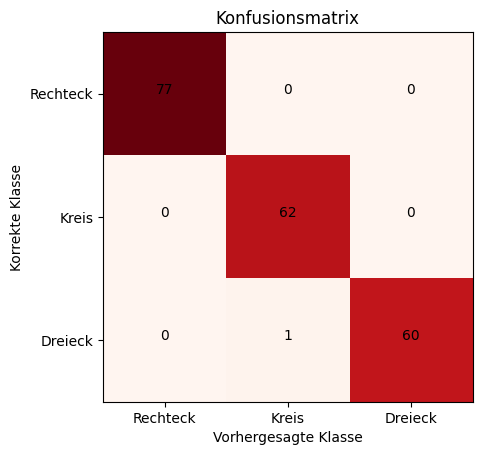

In [36]:
# Evaluation der Klassifikation
eval_class_prediction(class_test, model.predict(x_test)[1])

In [ ]:
%run Loesung/Loesung_2_5_3.py

#### Aufgabe 2.5.4:

Als Nächstes soll getestet werden, wie sich die Performance des Netzes auf leicht veränderten Bildern verhält. Dazu wird künstliches Rauschen auf die Bilder gelegt. Experimentieren Sie mit der Menge an Rauschen und beobachten Sie, wie sich die Performance des Netzes verhält.

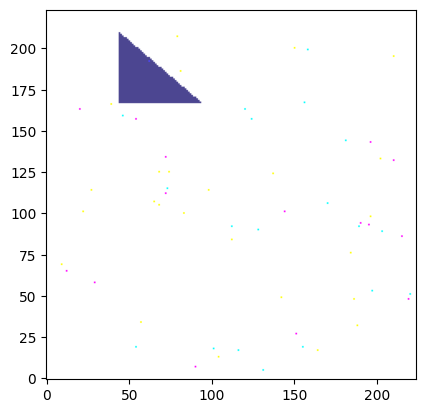

In [48]:
amount_of_noise = 0.001 # Menge an Rauschen

def noisy_image(input_imgs):
    noisy_imgs = np.copy(input_imgs)
    for i in range(len(input_imgs)):
        # Hinzufügen von "salt and pepper noise"
        noisy_imgs[i] = random_noise(noisy_imgs[i], mode='s&p', clip=True, amount=amount_of_noise)
    return noisy_imgs

x_test_noisy = noisy_image(x_test)

# Plotte Beispielbild mit Rauschen
plt.imshow(x_test_noisy[0], origin='lower')

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step
Korrekt vorhergesagte Bounding Boxen:  95 von 200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step
Korrekt vorhergesagte Klassen:  195 von 200


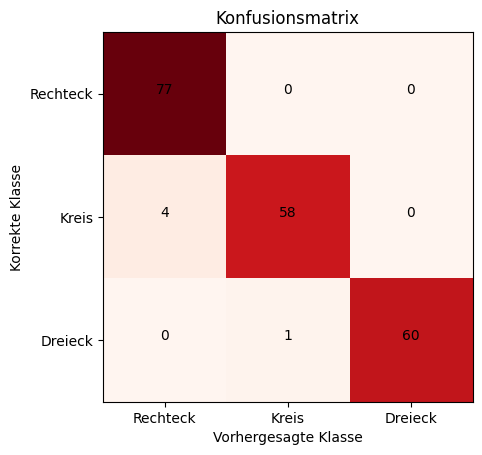

In [49]:
eval_bbox_prediction(bboxes_test,model.predict(x_test_noisy)[0],threshold=0.5)
eval_class_prediction(class_test, model.predict(x_test_noisy)[1])

In [ ]:
%run Loesung/Loesung_2_5_4.py

<a name="Uebung-1-6"></a>
### 2.6 Augumentierung der Daten

Die schlechte Extrapolationsfähigkeit von neuronalen Netzen wird insbesondere dann zum Problem, wenn der für das Training vorhandene Datensatz eher klein ist und hauptsächlich sehr ähnliche Daten enthält. In diesem Fall setzt man häufig sogenannte Augmentierung (engl. Augmentation) ein, um die Varianz und die Menge der Trainingsdaten zu erhöhen und so die Genauigkeit und die Robustheit des gelernten Machine Learning Modells zu verbessern. Bei der Augmentierung von Bilddaten (Image Augmentation) werden, basierend auf den vorhandenen Bildern, neue zusätzliche Bilder für das Training erzeugt. Dazu werden verschiedene Operationen wie zufällige Rotation, Spiegelung, Hinzufügen von künstlichem Rauschen, Veränderung des Kontrasts, etc. auf die ursprünglichen Bilder angewandt.

Beim Einsatz von synthetischen Daten führt die schlechte Extrapolationsfähigkeit von neuronalen Netzen häufig dazu, dass ein Modell, welches auf synthetischen Daten trainiert wurde und auf diesen eine sehr gute Performance erreicht, auf realen Daten eine deutlich schlechtere Performance zeigt. Dies liegt daran, dass sich die synthetischen Daten eigentlich immer in gewisser Weise von den realen Daten unterscheiden. Auch hier kann Augmentierung helfen ein robusteres Machine Learning Modell zu trainieren, welches besser generalisiert und auch in der Realität gute Vorhersagen liefert.

#### Aufgabe 2.6.1:

Wie bereits erläutert, können Bilder auf unterschiedliche Weise augmentiert werden. Im Folgenden sind vier Funktionen für die Augmentierung der synthetischen Bilder definiert. Wie verändern diese Funktionen die ursprünglichen Bilder?  

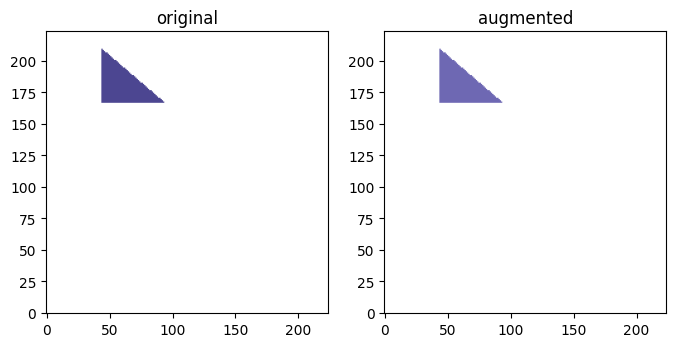

In [50]:
# Definition verschiedener Augmentierungsfunktionen

def brightness(image):
    max_val = 1-np.min(image)-0.4
    bright = np.random.random(1)*max_val
    im_bright = image + bright
    im_bright = np.clip(im_bright, 0.0, 1.0)
    return im_bright

def darkness(image):
    max_val = np.min(image)
    dark = np.random.random(1)*max_val
    im_dark = image - dark
    im_dark = np.clip(im_dark, 0.0, 1.0)
    return im_dark

def noise(image):
    amount = np.random.uniform(0.0,0.05,1)
    im_noise = random_noise(image, mode='s&p', clip=True, amount=amount[0])
    return im_noise

def blur(image):
    rand = np.random.randint(0,5)
    im_blur = cv.GaussianBlur(image,(5,5), rand)
    return(im_blur)

# Testbild augmentieren
original_img = x_test[0]
augmented_img = brightness(original_img) # brightness kann hier durch die anderen definierten Funktionen ersetzt werden

# Visualisierung
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1, title="original")
plt.imshow(original_img, origin="lower")
plt.subplot(1, 2, 2, title="augmented")
plt.imshow(augmented_img, origin="lower")

#### Aufgabe 2.6.2:

Im nächsten Schritt soll basierend auf dem Trainingsdatensatz ein gleich großer Datensatz mit augmentierten Bildern erzeugt werden. Betrachten Sie den folgenden Code und führen Sie ihn aus. Wie werden die augmentierten Bilder erzeugt?

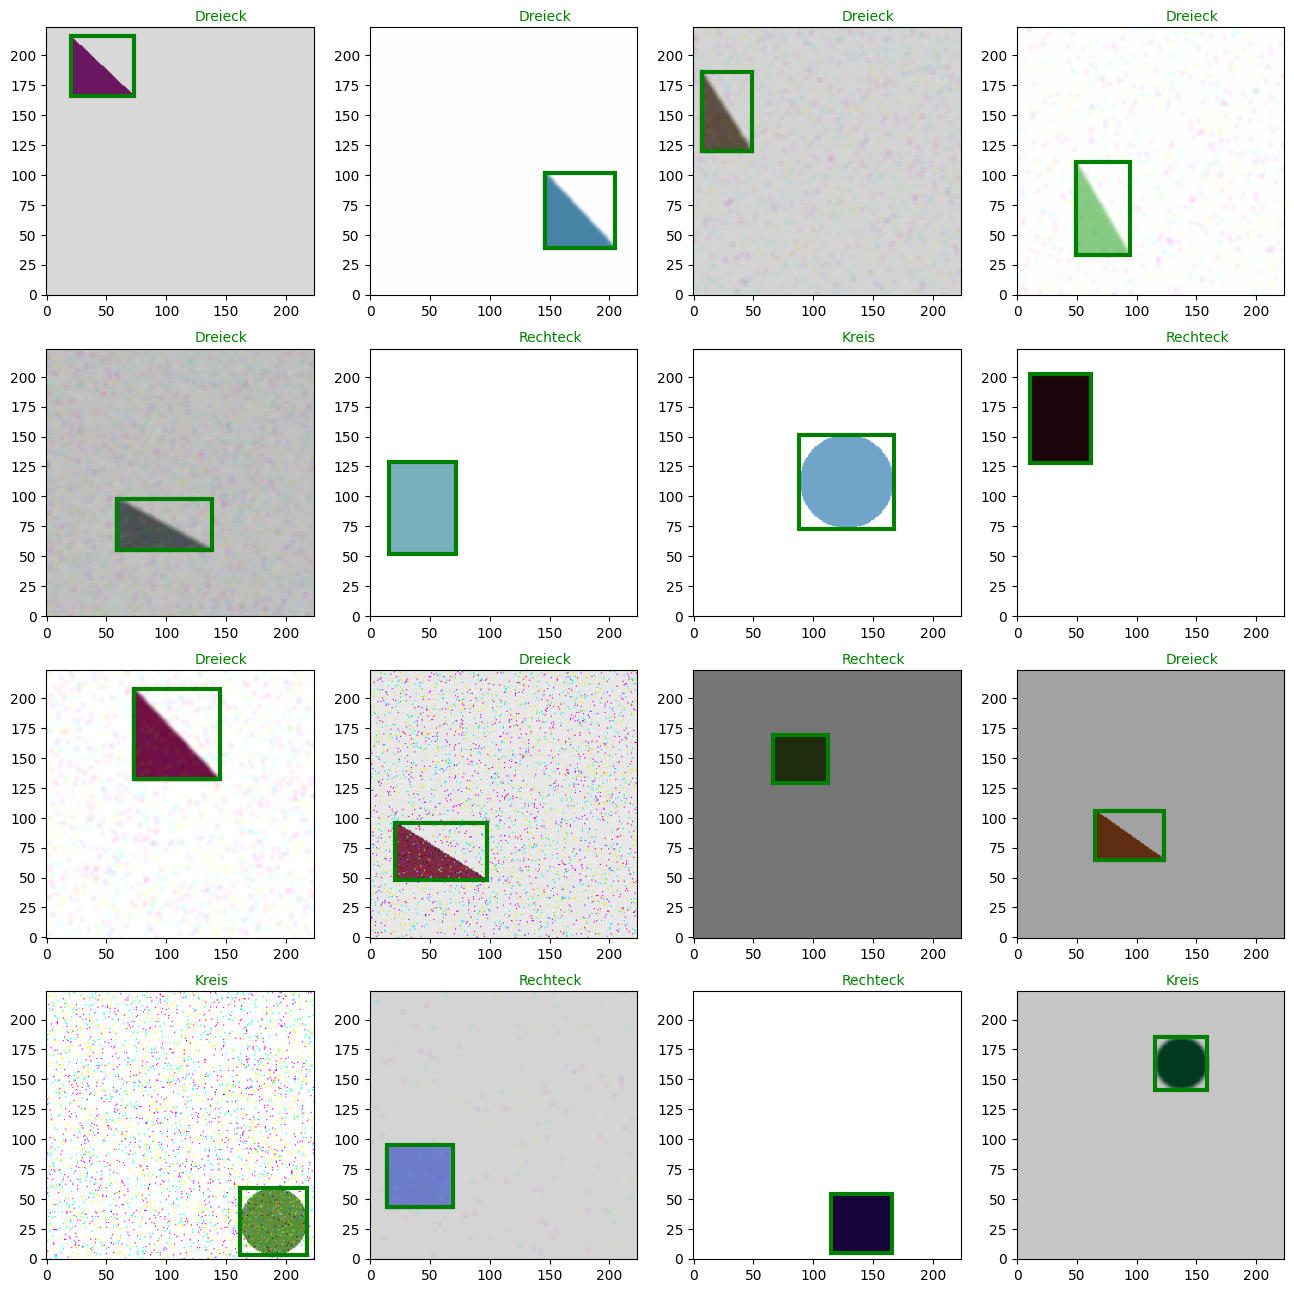

In [51]:
# Erzeugung eines Datensatzes mit augmentierten Bildern

def create_augmented_imgs(imgs,bboxes,classes):

    num_augimgs = len(imgs) # Anzahl zu erzeugender augmentierter Bilder

    # Platzhalter für augmentierte Bilder, Bounding Boxen und Klassen
    aug_imgs = np.ones(shape=imgs.shape)
    aug_bboxes = np.ones(shape=(num_augimgs,4))
    aug_classes = np.ones(shape=(num_augimgs,3))

    temp_train_imgs = np.array(imgs)

    for i in range(num_augimgs):
        sample = np.random.randint(len(temp_train_imgs)) # zufällige Wahl eines Bildes aus dem Trainingsdatensatz
        aug_img = temp_train_imgs[sample]
        aug = np.random.random(4) # zufällige Auswahl der Operationen, die auf das Bild angewandt werden
        if (aug[0]>0.5):
            aug_img = brightness(aug_img) # Aufhellung
        if (aug[1]>0.5):
            aug_img = darkness(aug_img) # Verdunklung
        if (aug[2]>0.5):
            aug_img = noise(aug_img) # Rauschen
        if (aug[3]>0.5):
            aug_img = blur(aug_img) # Unschärfe
        aug_imgs[i] = aug_img
        aug_bboxes[i] = bboxes[sample]
        aug_classes[i] = classes[sample]
    return aug_imgs, aug_bboxes, aug_classes

# Erzeugung augmentierter Bilddaten
aug_imgs, aug_bboxes, aug_classes = create_augmented_imgs(x_train, bboxes_train, class_train)

# Plotten einiger Beispielbilder
N,h,b,c = aug_imgs.shape
size = np.array([b,h,b,h])
plot_example_imgs(aug_imgs, aug_bboxes*size, aug_classes)

In [ ]:
%run Loesung/Loesung_2_6_2.py

<a name="Uebung-1-7"></a>
### 2.7 Training mit augumentiertem Datensatz

#### Aufgabe 2.7.1:

Im Folgenden ist der Code für neue Datensatz angepasst.  

Das Training des Modells benötigt ca. 20 Minuten. Falls das Training zu lange dauert, können Sie auch die Musterlösung laden.

In [52]:
# Erstellung eines neuen Trainingsdatensatzes mit den originalen und den augmentierten Bildern

x_train_aug = np.concatenate((x_train,aug_imgs), axis=0)
bboxes_train_aug = np.concatenate((bboxes_train,aug_bboxes), axis=0)
class_train_aug = np.concatenate((class_train,aug_classes), axis=0)

# Durchmischung der Bilder
x_train_aug, bboxes_train_aug, class_train_aug = shuffle(x_train_aug, bboxes_train_aug, class_train_aug)

In [54]:
lr = 0.001 # Lernrate
num_epochs = 20 # Anzahl Epochen
batch_size = 64 # Batch size

# Gewichtung der Fehler
w_1 = 10.0 # Lokalisierung
w_2 = 1.0 # Klassifizierung

# Laden der zufälligen Startgewichte des Netzes
model.load_weights('model_default.weights.h5')

opt = Adam(learning_rate=lr)

model.compile(loss={'output_bb' : 'mean_squared_error', 'output_class' : 'categorical_crossentropy'},
              loss_weights={'output_bb' : w_1, 'output_class' : w_2},
              optimizer=opt,
              metrics=['mae','accuracy'])

model_checkpoint_callback = ModelCheckpoint(
                            filepath="my_model_aug.keras", # diese Zeile wurde bereits geändert, um das alte Modell nicht zu überschreiben
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            save_weights_only=False)

history = model.fit(
                    x_train_aug,
                    (bboxes_train_aug, class_train_aug), # Hier wurde der alte durch den neuen Datensatz ersetzt
                    batch_size=batch_size,
                    epochs=num_epochs,
                    callbacks=[model_checkpoint_callback],
                    validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - loss: 1.6377 - output_bb_loss: 0.5358 - output_bb_mae: 0.1927 - output_class_accuracy: 0.3487 - output_class_loss: 1.1019 - val_loss: 1.4366 - val_output_bb_loss: 0.3423 - val_output_bb_mae: 0.1580 - val_output_class_accuracy: 0.4187 - val_output_class_loss: 1.0943
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 1.3944 - output_bb_loss: 0.2969 - output_bb_mae: 0.1420 - output_class_accuracy: 0.3277 - output_class_loss: 1.0975 - val_loss: 1.1765 - val_output_bb_loss: 0.0843 - val_output_bb_mae: 0.0726 - val_output_class_accuracy: 0.4031 - val_output_class_loss: 1.0922
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 1.2149 - output_bb_loss: 0.1273 - output_bb_mae: 0.0883 - output_class_accuracy: 0.3806 - output_class_loss: 1.0876 - val_loss: 1.1265 - val_output_bb_loss: 0.0480 - val_output_bb_mae: 0.0539 - val_output_class_accuracy: 0.4531 - val_output_class_loss: 1.0785
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/s

In [56]:
# Sie können entweder mit dem von Ihnen trainierten Netz weiterarbeiten oder mit der Musterlösung

# Von Ihnen trainiertes Netz laden
#model.load_weights('my_model_aug.keras')

# Musterlösung laden
model.load_weights('solution_model_aug.keras')

<a name="Uebung-1-8"></a>
### 2.8 Evaluation des neuen Modells

#### Aufgabe 2.8.1:

Testen Sie die Performance des neuen Modells, welches auf den originalen und den augmentierten Bildern trainiert wurde,
auf den Testdaten. Wie schneidet das neue Modell gegenüber dem alten Modell ab, welches nur auf den originalen Bildern trainiert wurde?

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step
Korrekt vorhergesagte Bounding Boxen:  156 von 200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step
Korrekt vorhergesagte Klassen:  198 von 200


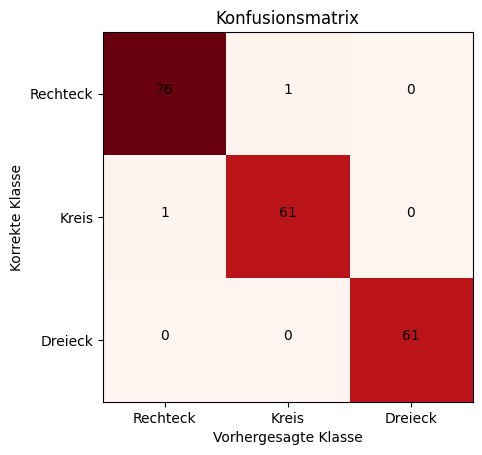

In [57]:
# Evaluation der Lokalisierung auf den Testdaten
threshold = 0.5 # Schwellwert IoU, ab dem Bounding Box als korrekt vorhergesagt betrachtet wird

box_true = bboxes_test
box_pred = model.predict(x_test)[0]

eval_bbox_prediction(box_true,box_pred,threshold)

# Evaluation der Klassifikation
eval_class_prediction(class_test, model.predict(x_test)[1])

In [ ]:
%run Loesung/Loesung_2_8_1.py

#### Aufgabe 2.8.2:

Testen Sie nun, wie sich die Performance des neuen Modells verhält, wenn man Rauschen auf die Bilder legt.

a) Experimentieren Sie mit der Menge an Rauschen. Wie schneidet das neue Modell im Vergleich mit dem alten Modell ab?

b) Bei der Augmentierung der Bilder wurde Rauschen in Form von sogenanntem 'salt and pepper noise' (mode='s&p') zu den Bildern hinzugefügt. Es gibt aber auch andere Arten von Rauschen. Wie gut ist die Performance des neuen Modells, wenn man die Art des Rauschens in 'gaussian' oder 'poisson' ändert? Was sagt dies über die Robustheit des Modells aus?  

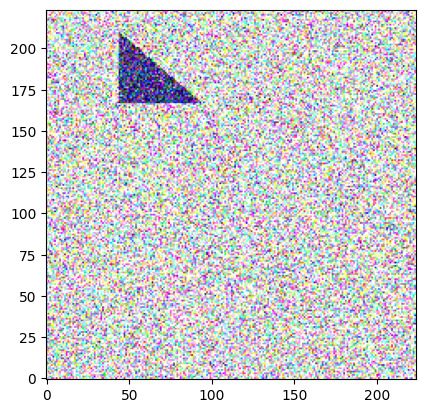

In [66]:
amount_of_noise = 0.001 # Menge an Rauschen

def noisy_image(input_imgs):
    noisy_imgs = np.copy(input_imgs)
    for i in range(len(input_imgs)):
        noisy_imgs[i] = random_noise(noisy_imgs[i], mode='s&p', clip=True, amount=amount_of_noise)
        #noisy_imgs[i] = random_noise(noisy_imgs[i], mode='gaussian')
        #noisy_imgs[i] = random_noise(noisy_imgs[i], mode='poisson')
    return noisy_imgs

x_test_noisy = noisy_image(x_test)

# Plotte Beispielbild mit Rauschen
plt.imshow(x_test_noisy[0], origin='lower')

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step
Korrekt vorhergesagte Bounding Boxen:  49 von 200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step
Korrekt vorhergesagte Klassen:  190 von 200


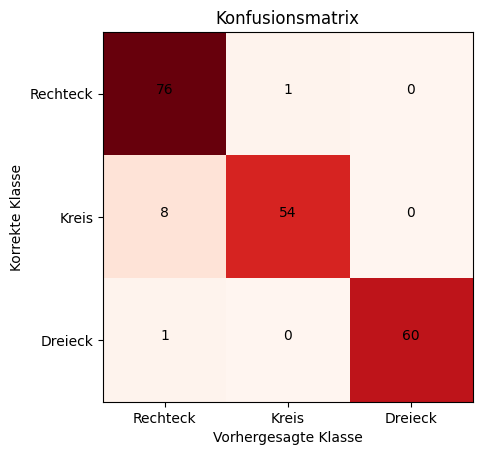

In [67]:
eval_bbox_prediction(bboxes_test,model.predict(x_test_noisy)[0],threshold=0.5)
eval_class_prediction(class_test, model.predict(x_test_noisy)[1])

<a name="Uebung-2"></a>
## 3. Übung mit realer Daten

Im Folgenden sollen die, anhand des simplen synthetischen Datensatzes kennengelernten, Ansätze und Methoden auf einen realen Datensatz übertragen werden. Ziel ist es, eine Objekt- und Lageerkennung für das Greifen unterschiedlicher, chaotisch bereitgestellter Objekte umzusetzen. Bei den Objekten handelt es sich um unterschiedliche Werkzeuge, die vom Roboter von einem Tisch gegriffen und anschließend an definierter Stelle wieder abgelegt werden sollen.

<a name="Uebung-2-1"></a>
### 3.1 Exploration des realen Datensatzes

#### Aufgabe 3.1.1:
  
Machen Sie sich zunächst mit dem realen Datensatz vertraut. Wie viele Bilder beinhaltet der Datensatz? In welcher Form werden Bilder und Labels hier gespeichert? Wie viele verschiedene Klassen beinhaltet der Datensatz? Betrachten Sie dazu auch beispielhaft einige der realen Bilder.

In [68]:
# Angleichen des realen Datensatzes an die bekannte Datenstruktur
%run data_transfer.py # dauert ca. 4min.

Realer Datensatz ist bereit.


<Figure size 640x480 with 0 Axes>

imgs: (694, 144, 256, 3)
bboxes: (694, 4)
classes: (694, 3)
Klassen: ['Schluessel', 'Schraubenzieher', 'Zange']


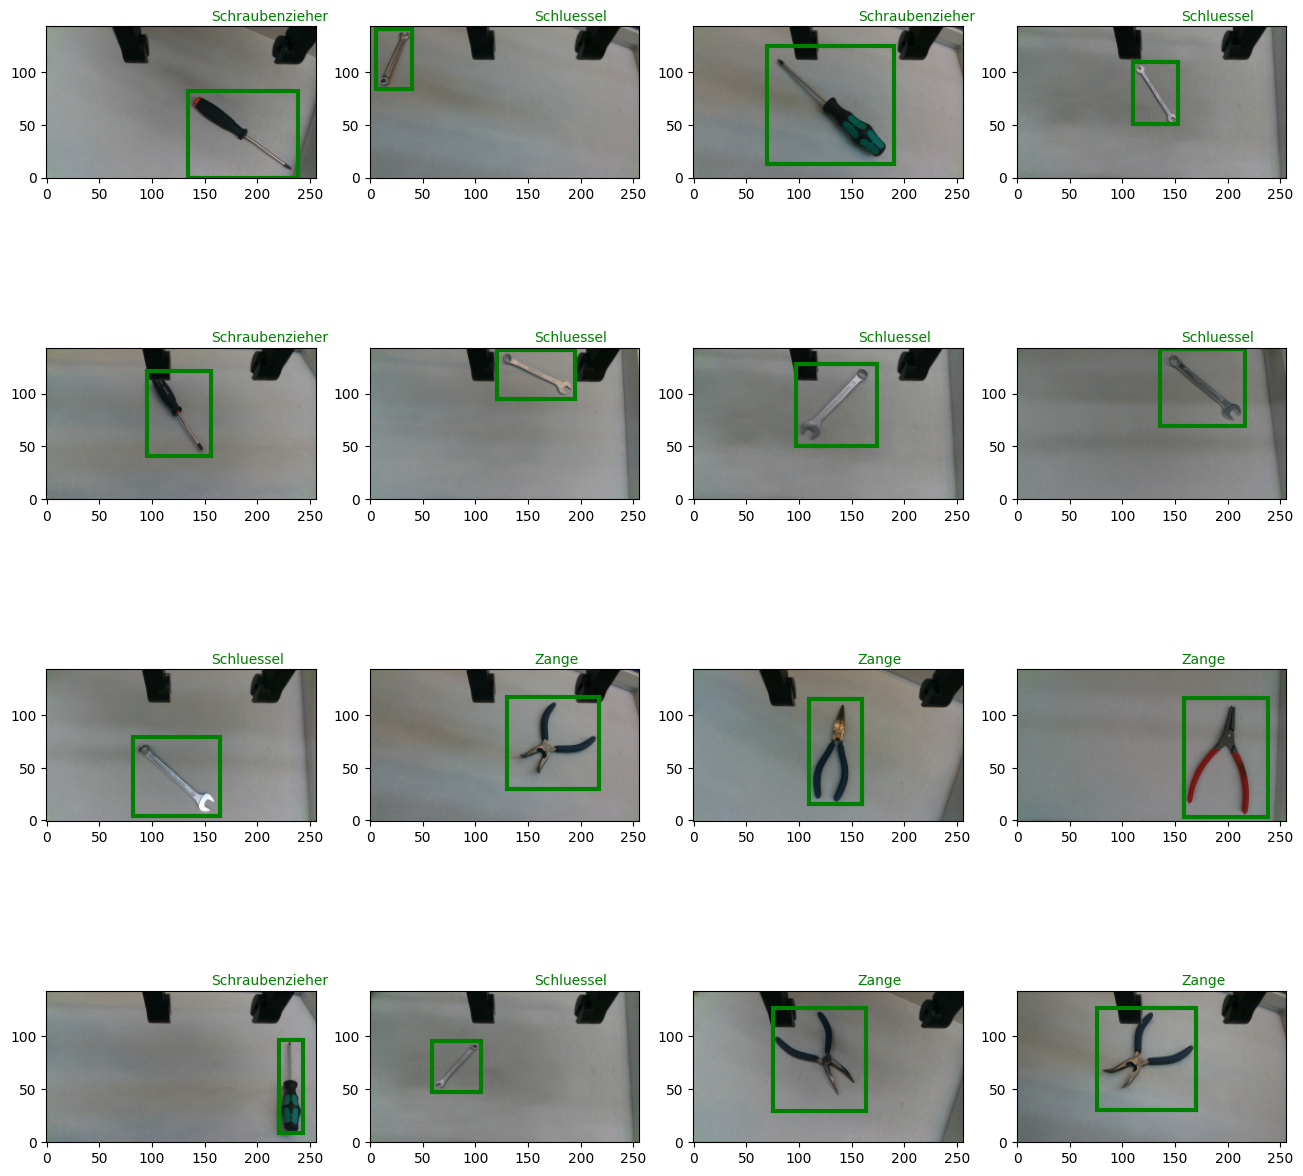

In [69]:
# Plotten einiger Beispielbilder
plot_example_imgs(imgs,bboxes,classes)

# Datenstruktur
print('imgs:', imgs.shape)
print('bboxes:', bboxes.shape)
print('classes:', classes.shape)

# Klassen
print('Klassen:',class_labels)

In [ ]:
%run Loesung/Loesung_3_1_1.py

<a name="Uebung-2-2"></a>
### 3.2 Datenvorverarbeitung für den realen Datensatz

#### Aufgabe 3.2.1:

Welche Vorverarbeitungsschritte wurden für den synthetischen Datensatz durchgeführt? Führen Sie die gleichen Vorverarbeitungsschritt für den realen Datensatz durch.

In [70]:
# Vorverarbeitungsschritt 1: Normalisierung der Pixelwerte
imgs_scaled = pixel_normalization(imgs)

# Vorverarbeitungsschritt 2: Normalisierung der Bounding Boxes
bboxes_scaled = bbox_normalization(bboxes, imgs)

Vorher:
tf.Tensor(
[[[126. 144. 131.]
  [132. 145. 131.]
  [137. 146. 133.]
  ...
  [ 99. 108.  93.]
  [ 95. 108.  89.]
  [ 97. 112.  96.]]

 [[135. 145. 130.]
  [131. 146. 131.]
  [135. 149. 135.]
  ...
  [ 95. 109.  96.]
  [ 90. 109.  92.]
  [ 96. 112.  96.]]

 [[133. 142. 127.]
  [134. 144. 130.]
  [134. 147. 135.]
  ...
  [ 98. 108. 100.]
  [ 94. 110.  96.]
  [100. 112.  98.]]

 ...

 [[104. 109.  97.]
  [ 99. 110.  94.]
  [102. 114.  99.]
  ...
  [ 89.  88.  71.]
  [ 85.  88.  69.]
  [ 85.  90.  72.]]

 [[ 97. 107.  94.]
  [100. 111.  97.]
  [102. 109.  94.]
  ...
  [ 86.  88.  72.]
  [ 85.  88.  71.]
  [ 86.  88.  71.]]

 [[101. 109.  92.]
  [ 99. 109.  92.]
  [105. 110.  96.]
  ...
  [ 86.  89.  70.]
  [ 86.  87.  67.]
  [ 87.  90.  68.]]], shape=(144, 256, 3), dtype=float32)
Nachher:
tf.Tensor(
[[[0.49411765 0.5647059  0.5137255 ]
  [0.5176471  0.5686275  0.5137255 ]
  [0.5372549  0.57254905 0.52156866]
  ...
  [0.3882353  0.42352942 0.3647059 ]
  [0.37254903 0.42352942 0.34901

In [71]:
# Durchmischen der Daten vor der Aufteilung
imgs_scaled_np = np.array(imgs_scaled)
imgs_scaled_np, bboxes_scaled, classes = shuffle(imgs_scaled_np, bboxes_scaled, classes)

n_train = int(0.8 * num_imgs) #Anzahl der Bilder, die zum Trainingsdatensatz gehören sollen

# Trainingsdaten
x_train = imgs_scaled_np[:n_train] # Die ersten n_train Bilder gehören zum Trainingsdatensatz
bboxes_train = bboxes_scaled[:n_train]
class_train = classes[:n_train]

# Testdaten
x_test = imgs_scaled_np[n_train:] # Die restlichen Bilder gehören zum Testdatensatz
bboxes_test = bboxes_scaled[n_train:]
class_test = classes[n_train:]

print("Anzahl Bilder Trainingsdatensatz: ", len(x_train))
print("Anzahl Bilder Testdatensatz: ", len(x_test))

Anzahl Bilder Trainingsdatensatz:  555
Anzahl Bilder Testdatensatz:  139


<a name="Uebung-2-3"></a>
### 3.3 Augumentierung des realen Datensatzes

#### Aufgabe 3.3.1:

Führen Sie den folgenden Code aus, um die Trainingsdaten mit augmentierten Bildern anzureichern und betrachten Sie einige Beispielbilder aus dem neuen Trainingsdatensatz.  

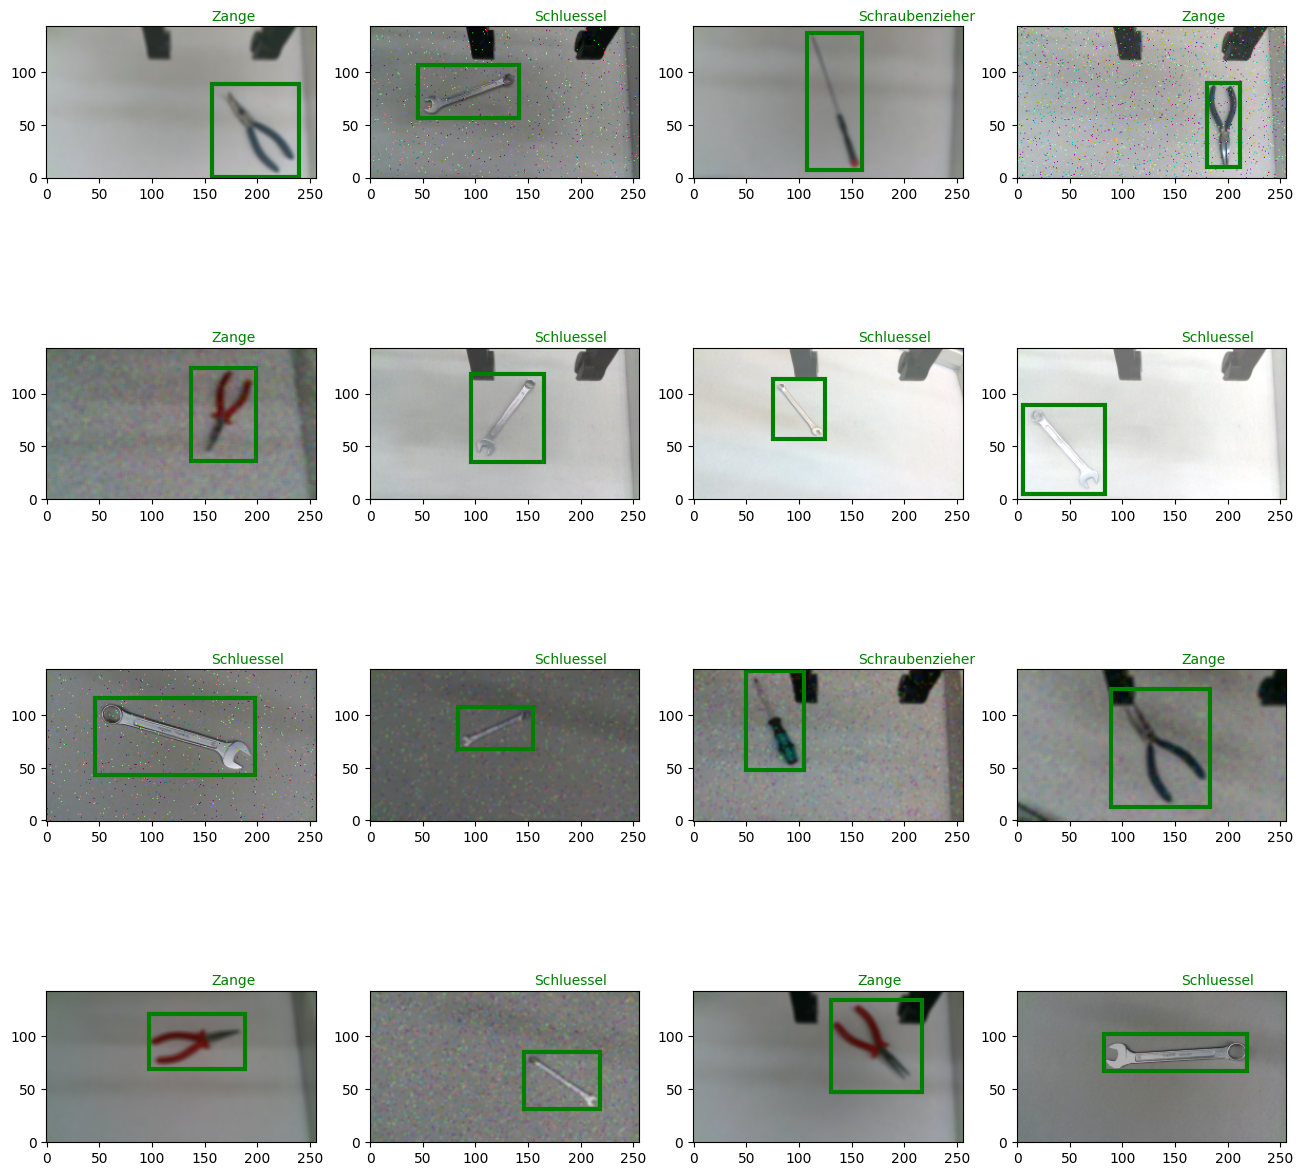

In [72]:
# Erzeugung augmentierter Bilddaten
aug_imgs, aug_bboxes, aug_classes = create_augmented_imgs(x_train, bboxes_train, class_train)

# Erstellung eines neuen Trainingsdatensatzes mit den originalen und den augmentierten Bildern
x_train_aug = np.concatenate((x_train,aug_imgs), axis=0)
bboxes_train_aug = np.concatenate((bboxes_train,aug_bboxes), axis=0)
class_train_aug = np.concatenate((class_train,aug_classes), axis=0)

# Durchmischung der Bilder
x_train_aug, bboxes_train_aug, class_train_aug = shuffle(x_train_aug, bboxes_train_aug, class_train_aug)

# Plotten einiger Beispielbilder
N,h,b,c = aug_imgs.shape
size = np.array([b,h,b,h])
plot_example_imgs(aug_imgs, aug_bboxes*size, aug_classes)

<a name="Uebung-2-4"></a>
### 3.4 Objekterkennung für den realen Datensatz

#### Aufgabe 3.4.1:

Das Format der Bilder unterscheidet sich zwischen dem synthetischen und dem realen Datensatz. Die realen Bilder haben das Format 144 x 256, während die synthetischen Bilder das Format 224 x 224 haben. Der Code ist allerdings so geschrieben, dass das unterschiedliche Format der Eingabedaten automatisch berücksichtigt wird und keine manuellen Änderungen vorgenommen werden müssen.

Bezogen auf das Format der Ausgabedaten gibt es keine Unterschiede zwischen den Datensätzen. Der reale Datensatz beinhaltet wie der synthetische Datensatz drei Klassen und bei beiden Datensätzen wird One-Hot-Encoding verwendet, um die korrekte Klasse anzugeben. Auch die Bounding Boxen sind bei beiden Datensätzen im gleichen Format gespeichert. Hier ergeben sich also ebenfalls keine Änderungen, so dass das Modell aus vorher eins zu eins verwendet werden kann.

In [73]:
def build_model():

    # Eingabe
    inputs = Input(shape=x_train.shape[1:])

    # CNN
    x = Convolution2D(filters=32,kernel_size=(3,3), activation="relu")(inputs)
    x = MaxPool2D(pool_size=(3,3))(x)
    x = Convolution2D(filters=16,kernel_size=(3,3), activation="relu")(x)
    x = MaxPool2D(pool_size=(3,3))(x)
    x = Convolution2D(filters=8,kernel_size=(3,3), activation="relu")(x)
    x = MaxPool2D(pool_size=(3,3)) (x)
    x = Flatten() (x)

    # Lokalisierung (Regressionsproblem)
    x_1 = Dense(128, activation="relu")(x)
    x_1 = Dropout(0.3)(x_1)
    x_1 = Dense(64,  activation="relu")(x_1)
    x_1 = Dropout(0.3)(x_1)
    output_bb = Dense(4, activation="sigmoid", name='output_bb')(x_1) # Ausgabe Bounding Box

    # Klassifizierung (Klassifikationsproblem)
    x_2 = Dense(64, activation="relu")(x)
    x_2 = Dropout(0.3)(x_2)
    x_2 = Dense(32, activation="relu")(x_2)
    x_2 = Dropout(0.3)(x_2)
    output_class = Dense(3, activation="softmax", name='output_class')(x_2) # Ausgabe Wahrscheinlichkeit Objektklasse

    model = Model(inputs=inputs, outputs=[output_bb, output_class])
    return model

model = build_model()

# Speichern der zufällig initialisierten Gewichte des Modells
model.save_weights('real_model_default.weights.h5')

Trainieren Sie das Modell auf den augmentierten Trainingsdaten für den realen Anwendungsfall.

Das Training des Modells benötigt ca. 20 Minuten. Falls das Training zu lange dauert, können Sie auch die Musterlösung laden.

In [74]:
lr = 0.001 # Lernrate
num_epochs = 40 # Anzahl Epochen
batch_size = 64 # Batch size

# Gewichtung der Fehler
w_1 = 10.0 # Lokalisierung
w_2 = 1.0 # Klassifizierung

# Laden der zufälligen Startgewichte des Netzes
model.load_weights('real_model_default.weights.h5')

opt = Adam(learning_rate=lr)

model.compile(loss={'output_bb' : 'mean_squared_error', 'output_class' : 'categorical_crossentropy'},
              loss_weights={'output_bb' : w_1, 'output_class' : w_2},
              optimizer=opt,
              metrics=['mae','accuracy'])

model_checkpoint_callback = ModelCheckpoint(
                            filepath="my_real_model_aug.keras",
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            save_weights_only=False)

history = model.fit(
                    x_train_aug,
                    (bboxes_train_aug, class_train_aug),
                    batch_size=batch_size,
                    epochs=num_epochs,
                    callbacks=[model_checkpoint_callback],
                    validation_split=0.2)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 1.7822 - output_bb_loss: 0.6767 - output_bb_mae: 0.2201 - output_class_accuracy: 0.3086 - output_class_loss: 1.1053 - val_loss: 1.4534 - val_output_bb_loss: 0.3684 - val_output_bb_mae: 0.1512 - val_output_class_accuracy: 0.3288 - val_output_class_loss: 1.0999
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 1.4751 - output_bb_loss: 0.3794 - output_bb_mae: 0.1591 - output_class_accuracy: 0.3602 - output_class_loss: 1.0957 - val_loss: 1.4369 - val_output_bb_loss: 0.3570 - val_output_bb_mae: 0.1485 - val_output_class_accuracy: 0.3559 - val_output_class_loss: 1.0962
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 1.4512 - output_bb_loss: 0.3567 - output_bb_mae: 0.1535 - output_class_accuracy: 0.3478 - output_class_loss: 1.0945 - val_loss: 1.4356 - val_output_bb_loss: 0.3572 - val_output_bb_mae: 0.1494 - val_output_class_accuracy: 0.3559 - val_output_class_loss: 1.0964
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/s

In [75]:
# Sie können entweder mit dem von Ihnen trainierten Netz weiterarbeiten oder mit der Musterlösung

# Von Ihnen trainiertes Netz laden
#model.load_weights('my_real_model_aug.keras')

# Musterlösung laden
model.load_weights('solution_real_model_aug.keras')

<a name="Uebung-2-5"></a>
### 3.5 Evaluation für den realen Datensatz

#### Aufgabe 3.5.1:

Testen Sie die Performance des trainierten Modells auf dem Testdatensatz. Wie gut funktioniert die Lokalisierung und die Klassifikation der Werkzeuge?

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step
Korrekt vorhergesagte Bounding Boxen:  71 von 139
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step
Korrekt vorhergesagte Klassen:  131 von 139


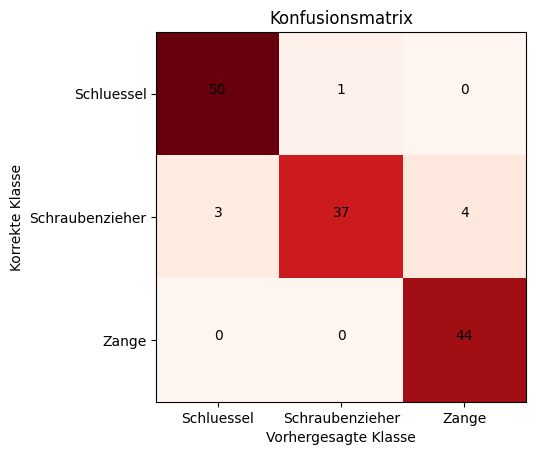

In [76]:
# Evaluation der Lokalisierung auf den Testdaten
threshold = 0.5 # Schwellwert IoU, ab dem Bounding Box als korrekt vorhergesagt betrachtet wird

box_true = bboxes_test
box_pred = model.predict(x_test)[0]

eval_bbox_prediction(box_true,box_pred,threshold)

# Evaluation der Klassifikation auf den Testdaten
eval_class_prediction(class_test, model.predict(x_test)[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


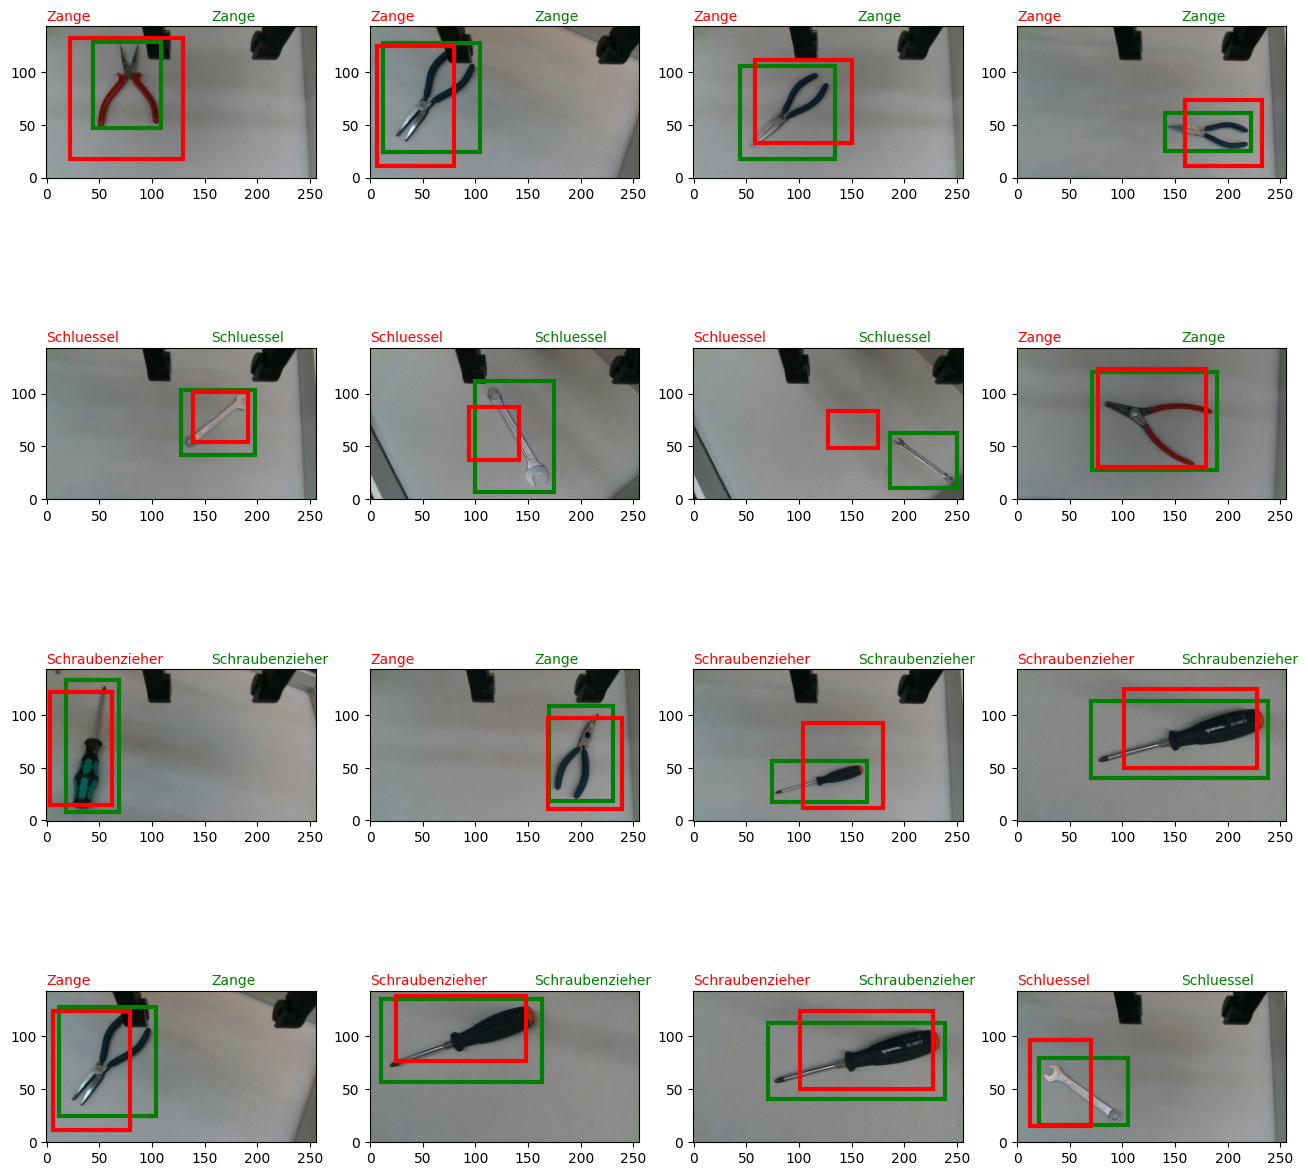

In [77]:
# Plotten die korrekten und die vom Netz vorhergesagten Bboxes und Klassen
N,h,b,c = x_test.shape
size = np.array([b,h,b,h])
plot_example_imgs_pred(x_test, bboxes_test, class_test, size, model)

#### Aufgabe 3.5.2:

Insbesondere bei der Lokalisierung gibt es in Bezug auf die Performance des Modells noch Luft nach oben. Überlegen Sie sich, wie die Performance des Modells möglicherweise verbessert werden könnte.  

In [ ]:
%run Loesung/Loesung_3_5_2.py